# Model Training process
This notebook was used to train the model
It follow those steps:
* Create the needed directories for the project
* Preprocess & load the dataset
* Preprocess/load additional dataset
* Normalize & categorize the labels
* Train the model
* Evaluate the model
* Plot error (If needed)
* Save the model (If needed)


################################################ Imports & Constants ####################################

In [1]:
import os
import pathlib

from config import config

CODA_DLL_PATH = config["preprocessing"]["coda_dll_path"]
H5_FILE = config["main"]["h5_file"]
CLASSES = config.get_classes()
IMG_SIZE = int(config["main"]["img_size"])

os.add_dll_directory(
    CODA_DLL_PATH
)  # https://github.co  m/tensorflow/tensorflow/issues/48868#issuecomment-841396124

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import preprocessing
import results
import vote
from plogging import logger

# makes the directories needed for files saved during the cells run (paths where files are saved)
def mkdir(path):
    pathlib.Path(path).mkdir(exist_ok=True)

mkdir("metrics")
mkdir("models")
mkdir("db")
mkdir("cache")

#### Define method to evaluate the model before and after voting
This method will evaluate the model, and will also return the results after the voting

In [2]:
def eval_model(history,x_test, y_test, y_pred, save=True):
    logger.info("Model stats:")
    results.plot_acc(history, save=save)
    results.plot_loss(history, save=save)
    results.log_stats(y_test, y_pred, save=save, file_path="metrics/stats_before_votes.txt")
    results.plot_roc(y_test, y_pred, zoom=False, save=save)
    results.plot_confusion_matrix(y_test, y_pred, save=save)
    
    logger.info("After votes:")
    y_pred_ = vote.vote(x_test, y_pred)
    results.log_stats(y_test, y_pred_, save=save, file_path="metrics/stats_aftervotes.txt")
    results.plot_roc(y_test, y_pred_, zoom=False, save=save)
    results.plot_confusion_matrix(y_test, y_pred_, save=save)
    return y_pred_

#####################################################################################################

### Load & preprocess the dataset
This cell preprocess (crop, rotate and resize) and returns the dataset, here I specified a high amount of test data, because most of the training was on the generated dataset.

In [3]:
x_train, x_test, y_train, y_test = preprocessing.load_labeled_dataset(H5_FILE, test_size=0.99, cache=True)
logger.info(y_train.value_counts())

[23:09:25] Creating labeled dataset started [h5_file=SynthText.h5]
[23:09:27] Collected db from catche [cache_path=cache/__base64__.h5]
[23:09:27] Function 'load_labeled_dataset' executed in 1.6093s
[23:09:27] Raleway        51
Ubuntu Mono    48
Russo One      47
Roboto         46
Alex Brush     38
Open Sans      28
Michroma       23
Name: font, dtype: int64


#### Load additional dataset
From h5 files, or generate one from h5 files outputted from the SynthText project

In [4]:
# this code generates new dataset, rather then reading one
# GENERATED_H5 = r"D:\results\SynthText_2000.h5"
# x_generated,y_generated = preprocessing.load_labeled_dataset(GENERATED_H5, cache=False, save=True, no_split=True)

H5_FILES = ["db/prep_81975r_unsplit_rest_2000.h5", "db/prep_78360r_unsplit_2000.h5"] 

for h5_file in H5_FILES:
    df = pd.read_hdf(h5_file)
    y_generated = df["font"]
    x_generated = df.drop(columns=["font"])

    x_train = pd.concat([x_train, x_generated])
    y_train = pd.concat([y_train, y_generated])

logger.info(y_train.value_counts())

[23:09:35] Ubuntu Mono    28439
Raleway        24968
Russo One      22972
Alex Brush     22622
Roboto         22150
Open Sans      21823
Michroma       17642
Name: font, dtype: int64


#### Move Y to categorical and prepare X data
Also normalize the test data (train data will be normalized by the `ImageDataGenerator`)

In [5]:
# move y to categorical

to_index = lambda s : CLASSES.index(s)
to_cat = lambda i : CAT_CLASSES[i]

ty_train = np.array(y_train.apply(to_index))
ty_test = np.array(y_test.apply(to_index))

CAT_CLASSES = tf.keras.utils.to_categorical(np.unique(ty_test))

y_train = to_cat(ty_train)
y_test = to_cat(ty_test)


In [6]:
x_test_norm = np.array(x_test["img"].to_list(), dtype=np.float32)/255
x_train = np.array(x_train["img"].to_list(), dtype=np.float32)

### Train the model
This is the main cell

In [7]:
optimizer = Adam(learning_rate=0.0001)

metrics_ = ["accuracy"]

logger.info(f"Train samples size [x_train={len(x_train)}, x_test={len(x_test_norm)}]")

callbacks = [EarlyStopping(monitor='val_accuracy', patience=5), ReduceLROnPlateau(monitor='val_loss',patience=3, verbose=1,factor=0.5,min_lr=0.00001)]

datagen = ImageDataGenerator(
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
        rotation_range=10,
        shear_range=10,
        brightness_range=(0.7, 1),
        validation_split=0.2,
        rescale=1./255
        )

model = Sequential([
    VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling="max"),
    Flatten(),
    BatchNormalization(),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])


train_gen = datagen.flow(x_train, y_train, batch_size=32, subset='training')
test_gen = datagen.flow(x_train, y_train, batch_size=8, subset='validation')

model.compile(optimizer=optimizer, metrics=metrics_, loss="categorical_crossentropy")

model.summary()
history = model.fit(train_gen, epochs=100, validation_data=test_gen, verbose=1, callbacks=callbacks, steps_per_epoch=train_gen.n//train_gen.batch_size, validation_steps=test_gen.n//test_gen.batch_size)


[23:09:42] Train samples size [x_train=160616, x_test=27916]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                             

### Evaluate the model
Print out accuracy, roc, convolution matrix, before and after voting

[01:25:44] Model stats:


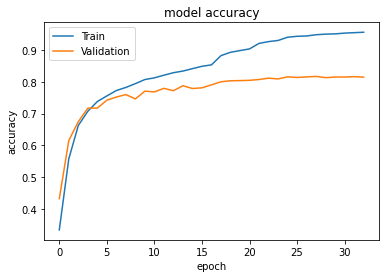

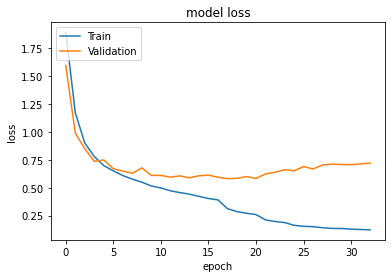

Accuracy: 0.800042986869812
Recall: 0.7899412512779236
Precision: 0.8195636868476868
AUC: 0.9539861679077148


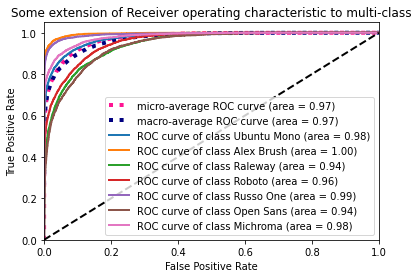

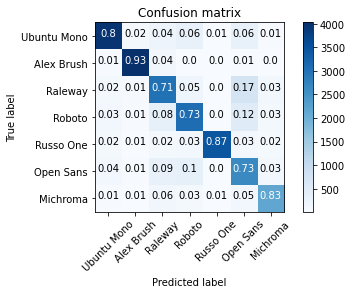

[01:25:46] After votes:
Accuracy: 0.8636982440948486
Recall: 0.8636982440948486
Precision: 0.8636982440948486
AUC: 0.9204906821250916


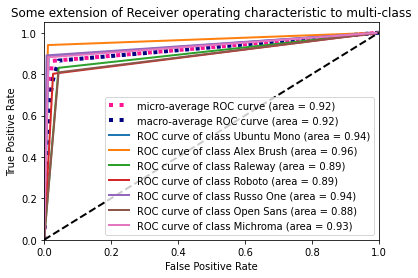

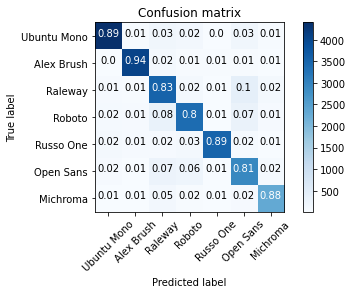

In [8]:
y_pred = model.predict(x_test_norm)
y_pred_after_votes = eval_model(history, x_test ,y_test, y_pred, save=True)

#### Print a sample of the models errors
Was by me from time to time just to see if there are any preprocess\label issues

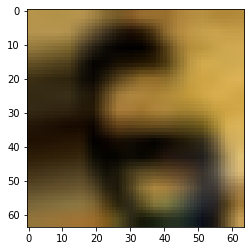

[01:26:10] Char: e
[01:26:10] Image: lion_30.jpg_0
[01:26:10] Predicted label: Open Sans
[01:26:10] True label: Ubuntu Mono


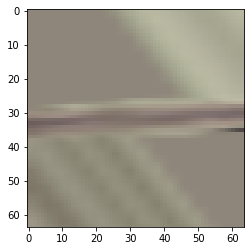

[01:26:10] Char: d
[01:26:10] Image: swan_14.jpg_0
[01:26:10] Predicted label: Roboto
[01:26:10] True label: Alex Brush


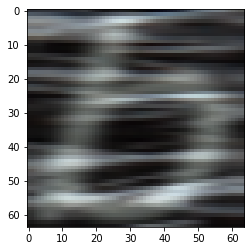

[01:26:10] Char: b
[01:26:10] Image: texture_85.jpg_0
[01:26:10] Predicted label: Raleway
[01:26:10] True label: Roboto


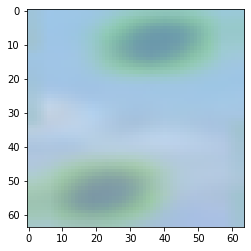

[01:26:10] Char: :
[01:26:10] Image: kite_54.jpg_0
[01:26:10] Predicted label: Roboto
[01:26:10] True label: Open Sans


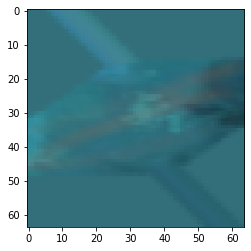

[01:26:10] Char: r
[01:26:10] Image: ballet_72.jpg_0
[01:26:10] Predicted label: Raleway
[01:26:10] True label: Alex Brush


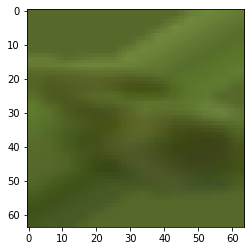

[01:26:10] Char: s
[01:26:10] Image: net_128.jpg_0
[01:26:10] Predicted label: Ubuntu Mono
[01:26:10] True label: Russo One


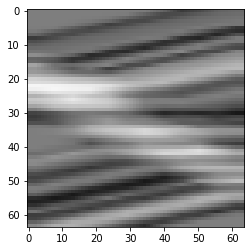

[01:26:10] Char: t
[01:26:10] Image: texture_67.jpg_0
[01:26:10] Predicted label: Open Sans
[01:26:10] True label: Raleway


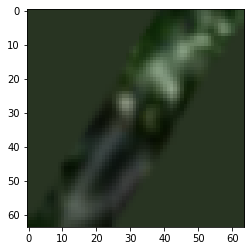

[01:26:10] Char: t
[01:26:10] Image: berkeley_126.jpg_0
[01:26:10] Predicted label: Raleway
[01:26:10] True label: Michroma


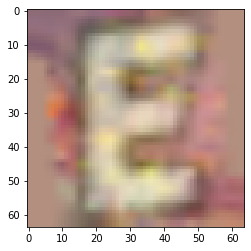

[01:26:10] Char: E
[01:26:10] Image: san+diego_4.jpg_0
[01:26:10] Predicted label: Roboto
[01:26:10] True label: Russo One


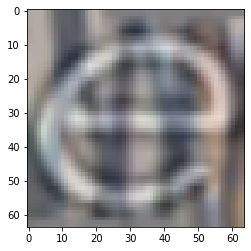

[01:26:10] Char: e
[01:26:10] Image: mesh_129.jpg_0
[01:26:10] Predicted label: Michroma
[01:26:10] True label: Raleway


In [9]:
SAMPLE_LEN = 10

predict = np.argmax(y_pred_after_votes, axis=1)
true_y_val = np.argmax(y_test, axis=1)
errors = np.flatnonzero(predict != true_y_val)

for i in np.random.choice(errors, SAMPLE_LEN):
    x_ = x_test.iloc[i, :]
    plt.imshow(x_["img"], cmap="gray")
    plt.show()
    logger.info("Char: {}".format(x_["char"]))
    logger.info("Image: {}".format(x_["img_name"]))
    logger.info("Predicted label: {}".format(CLASSES[predict[i]]))
    logger.info("True label: {}".format(CLASSES[true_y_val[i]]))

#### Save the model
If needed

In [ ]:
# saves the model to h5 and dot
MODEL_NAME = "final_model"
model.save(f"models/{MODEL_NAME}.h5")